# Meta-Training SNNs using MAML

## Imports 

In [1]:
import torch
import numpy as np

from torchmeta.utils.data import BatchMetaDataLoader

from snn_maml.utils import tensors_to_device, compute_accuracy

from snn_maml.benchmarks import get_benchmark_by_name
import snn_maml.utils as utils
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

## Data

In [3]:
from torchmeta.transforms import ClassSplitter, Categorical, Rotation
from torchvision import (
    transforms as trn,
)
import torch.nn.functional as F


In [4]:
data_config = {
    
    "name": "doublenmnistsequence",
    "dt": 1000,
    "chunk_size_test": 100,
    "chunk_size_train": 100,
    "num_shots": 100,
    "num_shots_test": 100,
    "num_ways": 1,
    "num_ways_val": 1,
    "batch_size" : 5,
    "folder": "./",
    "num_workers": 4,

}

In [5]:

benchmark = get_benchmark_by_name(
    data_config["name"],
    data_config["folder"],
    data_config["num_ways"],
    data_config["num_ways"],  # validation
    data_config["num_shots"],
    data_config["num_shots_test"],
    detach_at=None,
    hidden_size=64,
    params_file=None,
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    non_spiking=False,
    dt=data_config["dt"],
    chunk_size=data_config["chunk_size_train"],
)
meta_train_dataloader = BatchMetaDataLoader(
    benchmark.meta_train_dataset,
    batch_size=data_config["batch_size"],
    shuffle=True,
    num_workers=data_config["num_workers"],
    pin_memory=True,
)

meta_val_dataloader = BatchMetaDataLoader(
    benchmark.meta_val_dataset,
    batch_size=data_config["batch_size"],
    shuffle=True,
    num_workers=data_config["num_workers"],
    pin_memory=True,
)

meta_test_dataloader = BatchMetaDataLoader(
    benchmark.meta_test_dataset,
    batch_size=data_config["batch_size"],
    shuffle=True,
    num_workers=data_config["num_workers"],
    pin_memory=True,
)

USING PARAMS FROM .//parameters/decolle_params-CNN.yml


In [6]:
meta_train_dataloader.dataset

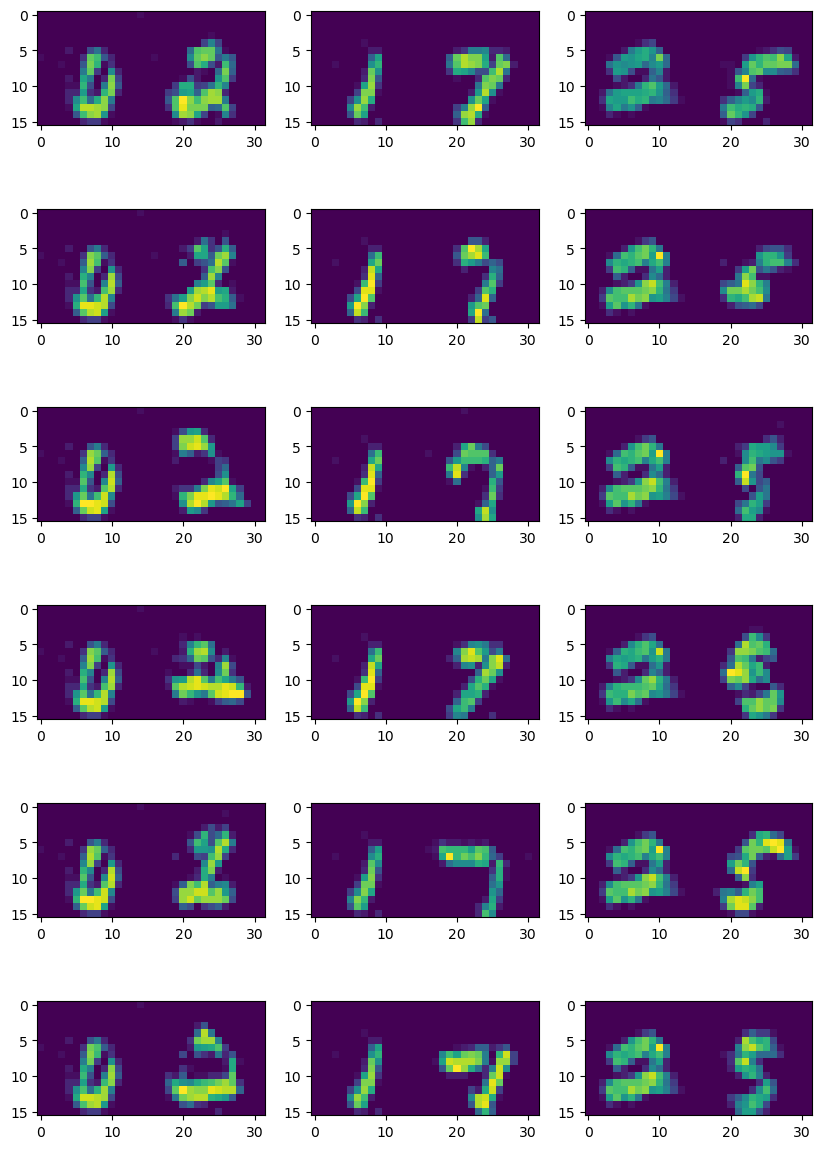

In [7]:
fig, axs = plt.subplots(6, 3, figsize=(10, 15))
for i, ax_p in enumerate(axs.T) : 
    for j, ax in enumerate(ax_p) : 
        data = meta_test_dataloader.dataset[{i}]["train"][j][0][1:].sum(0)[0]
        ax.imshow(data.cpu().numpy().T)

In [11]:
meta_train_dataloader.dataset[{3}]

OrderedDict([('train',
              <torchmeta.utils.data.task.SubsetTask at 0x7fd8e8741e20>),
             ('test',
              <torchmeta.utils.data.task.SubsetTask at 0x7fd8e8741e50>)])

In [9]:
train_data = next(iter(meta_train_dataloader))

In [10]:
train_data.keys()

odict_keys(['train', 'test'])

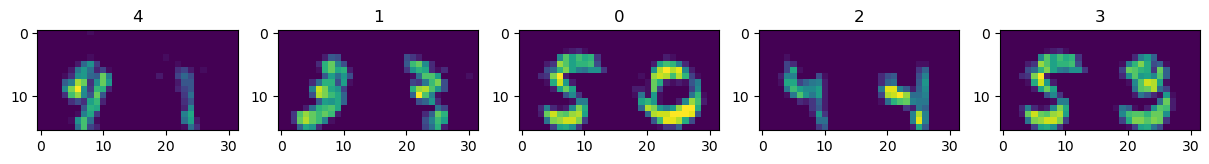

In [116]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for ax, d, t in zip(axs, train_data["train"][0][0].sum(1), train_data["train"][1][0]) : 
    ax.imshow(d[0].cpu().data.numpy().T)
    ax.set_title(t.item())

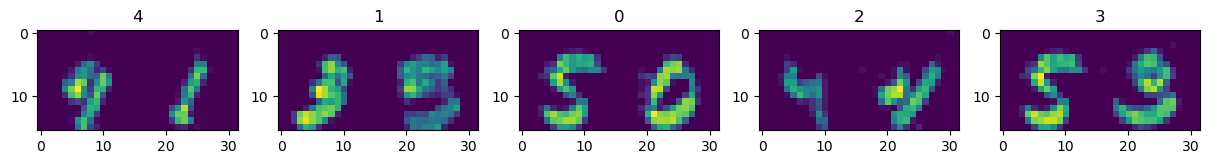

In [117]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for ax, d, t in zip(axs, train_data["test"][0][0].sum(1), train_data["test"][1][0]) : 
    ax.imshow(d[0].cpu().data.numpy().T)
    ax.set_title(t.item())

In [52]:
train_data["train"][0].unique()

tensor([0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
        6.0000e+00, 5.9350e+03, 5.9810e+03])

SyntaxError: unexpected EOF while parsing (3156706018.py, line 1)

## Models

In [23]:
from snn_maml.maml import ModelAgnosticMetaLearning as metalearner_model
from eventprop.models import SNN
from eventprop.config import get_flat_dict_from_nested

In [24]:
model_config = {
    "model_type": "snntorch",
    "snn": {
        "T": 50,
        "dt": 1,
        "tau_m": 20e-3,
        "tau_s": 5e-3,
    },
    "weights": {
        "init_mode": "kaiming_both",
        "scale": 5.5,
        "n_hid": [128, 64],
        "resolve_silent": False,
        "dropout": 0.0,
    },
    "device": (
        torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ),
}

flat_config = get_flat_dict_from_nested(model_config)

In [25]:
model = SNN([None, *flat_config.pop("n_hid"), 100], **flat_config)

Creating Spiking Linear with None -> 128
Creating Spiking Linear with 128 -> 64
Creating Spiking Linear with 64 -> 100


In [12]:
training_config = {
    "meta_lr" : 1e-3,
    "num_epochs" : 1,
    "first_order" : False,
    "num_steps": 1,

}

In [13]:
meta_optimizer = torch.optim.Adam(model.parameters(), lr=training_config['meta_lr'])
meta_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    meta_optimizer, eta_min=training_config['meta_lr'] / 50, T_max=training_config['num_epochs']
)

In [ ]:
metalearner = metalearner_model(
    model,
    meta_optimizer,
    first_order=args.first_order,
    num_adaptation_steps=args.num_steps,
    step_size=args.step_size,
    learn_step_size=args.learn_step_size,
    loss_function=benchmark.loss_function,
    scheduler=meta_scheduler,
    device=device,
    per_param_step_size=args.learn_step_size and args.per_param_step_size,
    boil=args.boil,
    outer_loop_quantizer=quantizer_out,
    inner_loop_quantizer=quantizer_in,
    **add_kwargs,
)